# Ranking ELO - Campeonato Brasileiro 2024

🧭 Introdução

O objetivo deste estudo é construir um Power Ranking dinâmico de clubes do Campeonato Brasileiro usando o sistema de pontuação ELO, uma métrica clássica de força relativa que se atualiza após cada partida. Diferente da tabela de pontos, que captura apenas o resultado bruto (3/1/0), o ELO incorpora contexto competitivo — quem você enfrentou, onde jogou e com qual margem — oferecendo uma leitura mais fiel do nível atual de cada time ao longo da temporada.

🎯 O que busco responder

- Quem são os times mais fortes agora, considerando a sequência de jogos e a qualidade dos adversários?

- Como a força dos clubes evolui no tempo (quedas, picos, consistência)?

- Qual é o impacto de jogar em casa e da margem de gols nos ajustes de força?


🧠 Por que ELO para futebol

O ELO é simples, interpretável e atualiza crenças a cada jogo. Ele tende a:

Recompensar vitórias contra adversários fortes e relativizar goleadas contra rivais fracos.

Capturar momentum (sequências positivas/negativas) sem depender de features complexas.

Servir como base para probabilidades pré-jogo, match previews, e scouting tático de calendário.



📦 Dados & Ferramentas

Dados de partidas (mandante/visitante, gols, data e campo neutro quando houver).

Stack: pandas para transformação, funções próprias para a lógica ELO (calcular_vantagem_casa, calcular_ajuste, atualizar_elo, gerar_ranking) e Plotly para gráficos interativos da evolução por time.

A fonte de dados foi o site FBRef, especializado em futebol.


## Importando a base

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel(r'E:\ELO Rating/2024.xlsx')
print('Dataset size: ', df.shape)
df

Dataset size:  (380, 14)


,Wk,Day,Date,Time,Time da Casa,xG,Score,xG.1,Time Visitante,Attendance,Venue,Referee,Match Report,Notes
0,1,Sat,2024-04-13,18:30:00,Internacional,1.9,2–1,0.7,Bahia,19.103,Estádio José Pinheiro Borba,NaN,Match Report,NaN
1,1,Sat,2024-04-13,18:30:00,Criciúma,0.7,1–1,0.6,Juventude,12.804,Estádio Heriberto Hülse,NaN,Match Report,NaN
2,1,Sat,2024-04-13,21:00:00,São Paulo,0.5,1–2,0.4,Fortaleza,35.055,Estádio do Morumbi,NaN,Match Report,NaN
3,1,Sat,2024-04-13,21:00:00,Fluminense,1.8,2–2,1.2,RB Bragantino,17.645,Estadio Jornalista Mário Filho,NaN,Match Report,NaN
4,1,Sun,2024-04-14,16:00:00,Vasco da Gama,0.9,2–1,1.2,Grêmio,17.722,Estádio Club de Regatas Vasco da Gama,Flavio Rodrigues de Souza,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,38,Sun,2024-12-08,16:00:00,Palmeiras,0.4,0–1,0.9,Fluminense,34.571,Allianz Parque,Ramon Abatti,Match Report,NaN
376,38,Sun,2024-12-08,16:00:00,Bahia,2.8,2–0,0.8,Atl Goianiense,48.476,Itaipava Arena Fonte Nova,Gustavo Ervino Bauermann,Match Report,NaN
377,38,Sun,2024-12-08,16:00:00,RB Bragantino,3.1,5–1,0.4,Criciúma,9.110,Estádio Nabi Abi Chedid,Savio Pereira,Match Report,NaN
378,38,Sun,2024-12-08,16:00:00,Botafogo (RJ),1.9,2–1,0.4,São Paulo,41.986,Estádio Nilton Santos,Anderson Daronco,Match Report,NaN


## Tratamento

Criando colunas para trazer o placar dos times em cada jogo

In [3]:
# Separar a coluna 'Score' em 'Gols Casa' e 'Gols Visitante'
df[['Gols Casa', 'Gols Visitante']] = df['Score'].str.split('–', expand=True)

# Remover espaços em branco
df['Gols Casa'] = df['Gols Casa'].str.strip()
df['Gols Visitante'] = df['Gols Visitante'].str.strip()

print("Colunas criadas com sucesso!")


Colunas criadas com sucesso!


## Criando o ELO

Definição dos parâmetros iniciais: todos os times começam com 2000 pontos de ELO, e o k-factor = 40 define o quanto cada resultado vai impactar o rating.

Criação do dicionário team_elo: estrutura que guarda o valor atual de ELO de cada clube.

Preenchimento automático: peguei todos os times que aparecem como mandante ou visitante e atribuí 2000 pontos para cada um.

📌 Resultado: agora todos os clubes têm um ELO inicial, pronto para ser atualizado a cada jogo.

In [4]:
# Inicialização de parâmetros
initial_elo = 2000  # Pontuação inicial para todos os times
k_factor = 40  # Ajuste básico do ELO, pode ser calibrado

# Criar dicionário para armazenar os pontos ELO de cada time
team_elo = {}

# Inicializar os ELOs de todos os times no dataset
for team in pd.concat([df['Time da Casa'], df['Time Visitante']]).unique():
    team_elo[team] = initial_elo

# Verificar inicialização
print("ELO inicial dos times:")
print(team_elo)

ELO inicial dos times:
{'Internacional': 2000, 'Criciúma': 2000, 'São Paulo': 2000, 'Fluminense': 2000, 'Vasco da Gama': 2000, 'Ath Paranaense': 2000, 'Atl Goianiense': 2000, 'Corinthians': 2000, 'Cruzeiro': 2000, 'Vitória': 2000, 'Bahia': 2000, 'RB Bragantino': 2000, 'Grêmio': 2000, 'Palmeiras': 2000, 'Fortaleza': 2000, 'Juventude': 2000, 'Atlético Mineiro': 2000, 'Flamengo': 2000, 'Botafogo (RJ)': 2000, 'Cuiabá': 2000}


### Preparação dos dados e vantagem de casa

Limpeza dos dados: converti as colunas de gols para número e substituí valores inválidos por zero, garantindo que não haja erro nos cálculos.

Vantagem de mando de campo: criei a função calcular_vantagem_casa para medir, em média, quantos gols a mais os times fazem em casa em comparação com fora.

Resultado prático: obtive um valor médio de vantagem (ex.: +0.35 gols), que será usado como ajuste no cálculo de expectativa de resultado.

📌 Resumo: agora os dados estão limpos e já sabemos qual é a força média de jogar em casa, pronta para entrar na fórmula do ELO.

In [5]:
# Converter as colunas 'Gols Casa' e 'Gols Visitante' para números
df['Gols Casa'] = pd.to_numeric(df['Gols Casa'], errors='coerce')
df['Gols Visitante'] = pd.to_numeric(df['Gols Visitante'], errors='coerce')

# Preencher valores NaN com 0 (caso tenha valores não numéricos anteriormente)
df['Gols Casa'] = df['Gols Casa'].fillna(0)
df['Gols Visitante'] = df['Gols Visitante'].fillna(0)

# Função para calcular a vantagem de jogar em casa
def calcular_vantagem_casa(df):
    """
    Calcula a vantagem média do time da casa.
    """
    # Soma dos gols marcados em casa e fora
    home_goals = df['Gols Casa'].sum()
    away_goals = df['Gols Visitante'].sum()
    
    # Calcular a vantagem média
    vantagem_casa = (home_goals - away_goals) / len(df)
    return vantagem_casa

# Calcular a vantagem de casa com a base de dados
home_advantage = calcular_vantagem_casa(df)
print(f"Vantagem média de jogar em casa: {home_advantage:.2f}")


Vantagem média de jogar em casa: 0.38


### Cálculo do ajuste do ELO

Função calcular_ajuste: responsável por definir quanto o rating de um time muda após cada partida.

Componentes principais:

- Expectativa de resultado: baseada na diferença de ELO entre os times e ajustada pela vantagem de jogar em casa.

- Diferença de gols: vitórias por placares mais elásticos geram ajustes maiores.

- Peso do campeonato: multiplica o impacto do jogo conforme a importância do torneio.

- Saída: um valor positivo (ganho de pontos) ou negativo (perda de pontos) que será somado ao ELO do time.

📌 Resumo: essa etapa cria a lógica central do modelo, que transforma resultados em mudanças de ELO de forma proporcional ao contexto da partida.

In [6]:
# Função para calcular o ajuste do ELO
def calcular_ajuste(elo_a, elo_b, resultado, diferenca_gols, forca_campeonato, home_advantage=0):
    """
    Calcula o ajuste de ELO para um time após um jogo.
    
    Parâmetros:
        elo_a (float): ELO do time A (time da casa).
        elo_b (float): ELO do time B (time visitante).
        resultado (float): Resultado do jogo (1 = vitória, 0.5 = empate, 0 = derrota).
        diferenca_gols (int): Diferença de gols no jogo.
        forca_campeonato (float): Peso do campeonato.
        home_advantage (float): Vantagem do time da casa.
    
    Retorno:
        ajuste (float): Ajuste do ELO para o time A.
    """
    # Probabilidade esperada de vitória para o time A
    prob_a = 1 / (1 + 10 ** ((elo_b - (elo_a + home_advantage)) / 400))
    
    # Fator de ajuste pela diferença de gols (exemplo: linear, pode ser refinado)
    diferenca_gols_factor = 1 + (abs(diferenca_gols) / 10)
    
    # Ajuste final com força do campeonato
    ajuste = k_factor * (resultado - prob_a) * diferenca_gols_factor * forca_campeonato
    return ajuste


### Atualização do ELO jogo a jogo

Função atualizar_elo: percorre cada partida do dataset e ajusta os ratings dos dois times.

Passos principais:

- Identificação do contexto: time da casa, visitante e gols.

- Resultado do jogo: vitória, empate ou derrota convertidos em valores (1, 0.5, 0).

- Diferença de gols: usada para aumentar o impacto de vitórias mais elásticas.

- Ajustes calculados: aplica a função calcular_ajuste para ambos os times (casa e visitante).

Atualização do dicionário: os novos valores substituem os anteriores em team_elo.

📌 Resumo: essa etapa é responsável por rodar todo o histórico de jogos e atualizar o rating de cada clube, resultando no ELO final da temporada.

In [7]:
# Função para processar os jogos e atualizar os ELOs, considerando campo neutro
def atualizar_elo(df, team_elo, home_advantage):
    """
    Atualiza os pontos ELO dos times com base nos resultados dos jogos e se o jogo foi em campo neutro.
    
    Parâmetros:
        df (DataFrame): DataFrame contendo os dados dos jogos.
        team_elo (dict): Dicionário com os ELOs atuais de cada time.
        home_advantage (float): Vantagem média de jogar em casa.
    
    Retorno:
        team_elo (dict): Dicionário atualizado com os ELOs dos times.
    """
    for index, row in df.iterrows():
        # Dados da partida
        time_casa = row['Time da Casa']
        time_visitante = row['Time Visitante']
        gols_casa = row['Gols Casa']
        gols_visitante = row['Gols Visitante']
        campo_neutro = row.get('Campo Neutro', 'Não')  # Padrão para "Não" caso não exista a coluna
        forca_campeonato = 1  # Placeholder, pode ser ajustado com base no campeonato
        
        # Definir a vantagem de casa
        if campo_neutro == "Sim":
            vantagem_casa = 0
        else:
            vantagem_casa = home_advantage
        
        # Resultado do jogo (1 = vitória casa, 0.5 = empate, 0 = vitória visitante)
        if gols_casa > gols_visitante:
            resultado_casa = 1
            resultado_visitante = 0
        elif gols_casa < gols_visitante:
            resultado_casa = 0
            resultado_visitante = 1
        else:
            resultado_casa = 0.5
            resultado_visitante = 0.5
        
        # Diferença de gols
        diferenca_gols = abs(gols_casa - gols_visitante)
        
        # ELO atual dos times
        elo_casa = team_elo[time_casa]
        elo_visitante = team_elo[time_visitante]
        
        # Calcular ajustes
        ajuste_casa = calcular_ajuste(elo_casa, elo_visitante, resultado_casa, diferenca_gols, forca_campeonato, vantagem_casa)
        ajuste_visitante = calcular_ajuste(elo_visitante, elo_casa, resultado_visitante, diferenca_gols, forca_campeonato, -vantagem_casa)
        
        # Atualizar os ELOs
        team_elo[time_casa] += ajuste_casa
        team_elo[time_visitante] += ajuste_visitante
    
    return team_elo

# Atualizar os ELOs com base nos jogos
team_elo = atualizar_elo(df, team_elo, home_advantage)

# Verificar ELO final dos times
print("ELO atualizado dos times:")
print(team_elo)


ELO atualizado dos times:
{'Internacional': 2089.9689150220324, 'Criciúma': 1871.648189493148, 'São Paulo': 1997.2400364851608, 'Fluminense': 2021.4843667361404, 'Vasco da Gama': 1991.8670394106102, 'Ath Paranaense': 1886.1276866491753, 'Atl Goianiense': 1870.419029216522, 'Corinthians': 2134.871372379716, 'Cruzeiro': 1958.8374774357942, 'Vitória': 2041.7654388217904, 'Bahia': 1952.447515554062, 'RB Bragantino': 1964.9154585181675, 'Grêmio': 1984.0220477369598, 'Palmeiras': 2102.864279847334, 'Fortaleza': 2077.619369879073, 'Juventude': 1954.0730265115023, 'Atlético Mineiro': 1939.5405016174589, 'Flamengo': 2113.3452353507537, 'Botafogo (RJ)': 2200.274218042401, 'Cuiabá': 1846.668795292201}


## Gerando o Ranking

In [8]:
# Converter o dicionário de ELO em um DataFrame para ordenação
def gerar_ranking(team_elo):
    """
    Gera um ranking dos times baseado no ELO atual.
    
    Parâmetros:
        team_elo (dict): Dicionário com os ELOs dos times.
    
    Retorno:
        ranking_df (DataFrame): DataFrame contendo os times ordenados por ELO.
    """
    ranking_df = pd.DataFrame(team_elo.items(), columns=['Time', 'ELO'])
    ranking_df = ranking_df.sort_values(by='ELO', ascending=False).reset_index(drop=True)
    return ranking_df

# Gerar o ranking
ranking_df = gerar_ranking(team_elo)

# Exibir o ranking
print("Ranking dos times baseado no ELO:")
print(ranking_df)


Ranking dos times baseado no ELO:
                Time          ELO
0      Botafogo (RJ)  2200.274218
1        Corinthians  2134.871372
2           Flamengo  2113.345235
3          Palmeiras  2102.864280
4      Internacional  2089.968915
5          Fortaleza  2077.619370
6            Vitória  2041.765439
7         Fluminense  2021.484367
8          São Paulo  1997.240036
9      Vasco da Gama  1991.867039
10            Grêmio  1984.022048
11     RB Bragantino  1964.915459
12          Cruzeiro  1958.837477
13         Juventude  1954.073027
14             Bahia  1952.447516
15  Atlético Mineiro  1939.540502
16    Ath Paranaense  1886.127687
17          Criciúma  1871.648189
18    Atl Goianiense  1870.419029
19            Cuiabá  1846.668795


## Criação do gráfico interativo com a evolução de ELO por Data

In [9]:
import plotly.graph_objects as go

df['Data'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)


# Criar dicionário para armazenar os pontos ELO ao longo do tempo
elo_history = {team: [] for team in pd.concat([df['Time da Casa'], df['Time Visitante']]).unique()}
elo_history['Data'] = []

# Parâmetros iniciais
initial_elo = 2000
team_elo = {team: initial_elo for team in elo_history if team != 'Data'}


# Processar os jogos e armazenar a evolução dos ELOs
for index, row in df.iterrows():
    time_casa = row['Time da Casa']
    time_visitante = row['Time Visitante']
    gols_casa = row['Gols Casa']
    gols_visitante = row['Gols Visitante']
    data = row['Data']
    
    resultado_casa = 1 if gols_casa > gols_visitante else 0.5 if gols_casa == gols_visitante else 0
    resultado_visitante = 1 - resultado_casa
    
    diferenca_gols = abs(gols_casa - gols_visitante)
    home_advantage = calcular_vantagem_casa(df)
    
    # Atualizar os ELOs
    elo_casa = team_elo[time_casa]
    elo_visitante = team_elo[time_visitante]
    
    ajuste_casa = calcular_ajuste(elo_casa, elo_visitante, resultado_casa, diferenca_gols, 1, home_advantage)
    ajuste_visitante = calcular_ajuste(elo_visitante, elo_casa, resultado_visitante, diferenca_gols, 1, -home_advantage)
    
    team_elo[time_casa] += ajuste_casa
    team_elo[time_visitante] += ajuste_visitante
    
    # Armazenar os valores do ELO após a partida
    for team in team_elo.keys():
        elo_history[team].append(team_elo[team])
    elo_history['Data'].append(data)

# Converter o histórico de ELO em um DataFrame
elo_df = pd.DataFrame(elo_history)

# Preencher valores ausentes com o ELO inicial
elo_df = elo_df.fillna(initial_elo)

# Ordenar os times pela pontuação atual de ELO
sorted_teams = sorted(team_elo.keys(), key=lambda x: team_elo[x], reverse=True)

# Garantir que a coluna de datas está no formato correto
elo_df['Data'] = pd.to_datetime(elo_df['Data'])

# Criar o gráfico interativo
fig = go.Figure()

# Adicionar linhas para cada time na ordem do ELO
for team in sorted_teams:
    fig.add_trace(go.Scatter(
        x=elo_df['Data'], 
        y=elo_df[team],
        mode='lines',
        name=f"{team} ({team_elo[team]:.1f})"  # Exibir ELO atual na legenda
    ))

# Personalizar layout
fig.update_layout(
    title='Evolução do ELO dos Times',
    xaxis=dict(
        range=[elo_df['Data'].min(), elo_df['Data'].max()],  # Ajustar a escala do eixo X
        title='Data'
    ),
    yaxis_title='Pontuação ELO',
    legend_title='Times (ELO Atual)',
    hovermode='x unified',
    template='plotly_white',
    width=900,
    height=600
)

# Exibir o gráfico
fig.show()




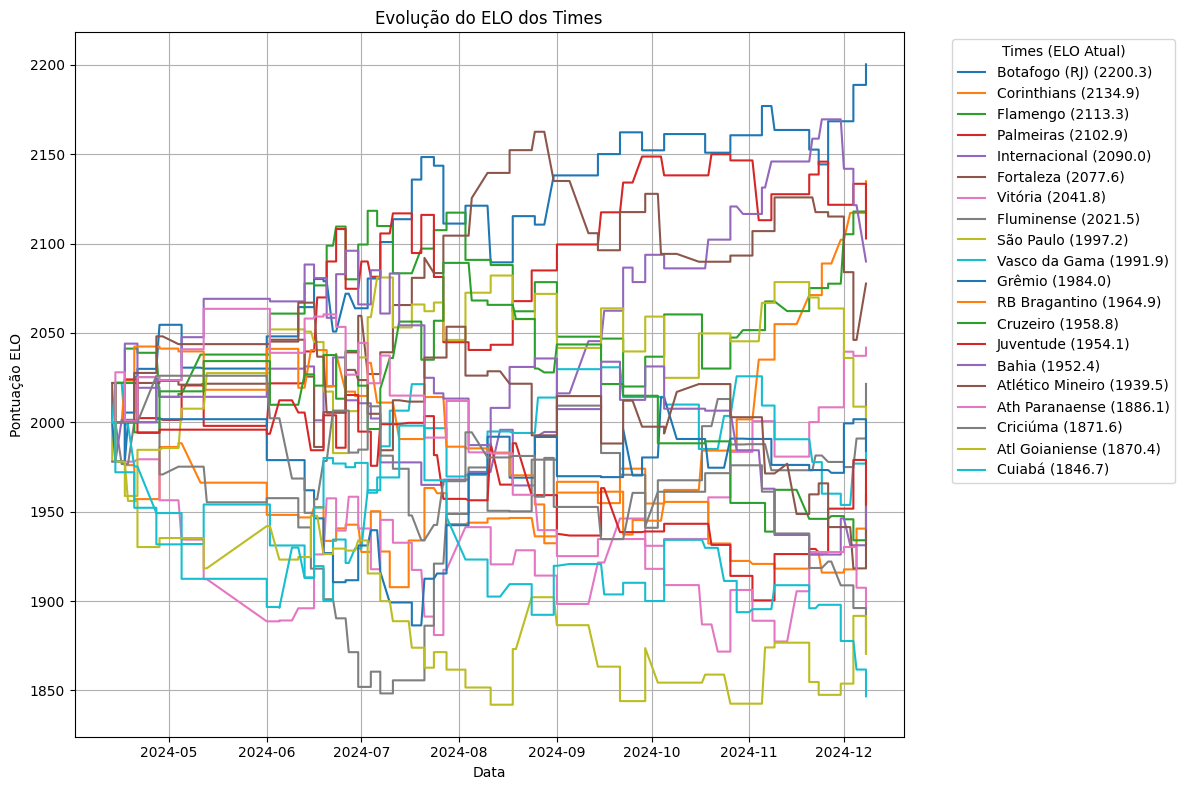

In [10]:
# Importar matplotlib
import matplotlib.pyplot as plt

# Criar gráfico estático usando matplotlib
plt.figure(figsize=(12, 8))

# Adicionar linhas para cada time na ordem do ELO
for team in sorted_teams:
    plt.plot(elo_df['Data'], elo_df[team], label=f"{team} ({team_elo[team]:.1f})")

# Personalizar layout
plt.title('Evolução do ELO dos Times')
plt.xlabel('Data')
plt.ylabel('Pontuação ELO')
plt.legend(title='Times (ELO Atual)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()



# 📊 Insights Finais  

O Ranking **ELO** permitiu analisar a temporada além da tabela de pontos, captando **momentum**, oscilações de desempenho e validações importantes do modelo.  

### ✅ Validações do modelo  
- **Botafogo**: campeão no Brasileirão e também líder no ELO. Isso mostra a qualidade do modelo em refletir a dominância real do time.  
- O modelo também acertou os **4 últimos colocados**, confirmando o rebaixamento de forma consistente.  

### ⚡ Dinâmica de momentum  
- **Corinthians**: 2º no Ranking ELO, puxado pela sequência de **9 vitórias seguidas**. O time saiu da zona de rebaixamento para a Pré-Libertadores.  
- **Bahia**: trajetória oposta, fechando o Brasileirão em 8º, mas caindo para 15º no ELO devido ao **fim de campeonato ruim**, quase perdendo a vaga na Libertadores.  

### 📈 Destaques positivos  
- **Fortaleza**: chegou a liderar o Ranking ELO em setembro, reflexo do bom momento em que disputava a liderança. Apesar da queda, mostra o impacto de picos de desempenho.  
- **Vitória**: começou na lanterna do ELO e lutando contra o rebaixamento, mas terminou **11º no campeonato e 7º no ELO**, uma recuperação notável.  

### 📉 Destaques negativos  
- **Atlético-MG**: mesmo chegando em finais de Copas, o time viveu péssima campanha no Brasileirão e terminou com risco real de rebaixamento, o que foi captado pelo ELO.  

---

📌 **Conclusão:**  
O ELO não só refletiu os resultados finais da tabela, mas trouxe uma visão extra de **momentum, consistência e volatilidade**. Para análise de performance, scouting ou até previsão de jogos, mostrou ser um **instrumento robusto e interpretável**.  
